In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import glob
from scipy.integrate import solve_ivp
from multiprocessing import cpu_count, Pool

In [2]:
class ElasticPendulum:
    """
    """
    def __init__(self, alpha_0=None, beta_0=None, t_end=2, dt=0.001, fig_cache='_figs', cores=None):
        self.g = 9.81
        if alpha_0 is not None:
            self.alpha_0 = alpha_0
        else:
            self.alpha_0 = np.random.uniform(-np.pi, np.pi)
            
        if beta_0 is not None:
            self.beta_0 = beta_0
        else:
            self.beta_0 = np.random.uniform(-np.pi, np.pi)
            
        self.fig_cache = fig_cache
        if not os.path.exists(self.fig_cache):
            os.mkdir(self.fig_cache)
    
        self.alpha_1 = 0.
        self.beta_1 = 0.
        
        self.a0 = 1.
        self.b0 = 1.
        self.a1 = 0.
        self.b1 = 0.
        self.dt = dt
        self.t_end = t_end
        
        #
        self.l1 = 1.
        self.l2 = 1.
        self.m1 = 1.
        self.m2 = 1.
        self.k1 = np.random.uniform(35, 55)
        self.k2 = np.random.uniform(35, 55)
  
        self.t_eval = np.arange(0, self.t_end, self.dt)
        if cores is None:
            self.cores = cpu_count()
        else:
            self.cores = cores

    def _alpha_pp(self, t, Y):
        # Y[0] = alpha_1, Y[1] = alpha_0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, _ = Y
        return (-(self.g * self.m1 * np.sin(alpha_0) - self.k2 * self.l2 * np.sin(alpha_0 - beta_0) +
                  self.k2 * b0 * np.sin(alpha_0 - beta_0) + 
                  2 * self.m1 * a1 * alpha_1) / (self.m1 * a0))
    
    def _beta_pp(self, t, Y):
        # Y[0] = beta_1, Y[1] = beta_0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, b1 = Y
        return ((-self.k1 * self.l1 * np.sin(alpha_0 - beta_0) + 
                 self.k1 * a0 * np.sin(alpha_0 - beta_0) -
                 2. * self.m1 * b1 * beta_1) / (self.m1 * b0))
    
    def _a_pp(self, t, Y):
        # Y[0] = a1, Y[1] = a0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, b1 = Y
        return ((self.k1 * self.l1 + self.g * self.m1 * np.cos(alpha_0) - 
                 self.k2 * self.l2 * np.cos(alpha_0 - beta_0) + 
                 self.k2 * b0 * np.cos(alpha_0 - beta_0) + 
                 a0 * (-self.k1 + self.m1 * alpha_1 ** 2)) / self.m1)
    
    def _b_pp(self, t, Y):
        # Y[0] = b1, Y[1] = b0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, b1 = Y
        return ((self.k2 * self.l2 * self.m1 + 
                 self.k2 * self.l2 * self.m2 * np.cos(alpha_0 - beta_0) +
                 self.k1 * self.m2 * a0 * np.cos(alpha_0 - beta_0) -
                 b0 * (self.k2 * (self.m1 + self.m2) - self.m1 * self.m2 * beta_1 ** 2)) / (self.m1 * self.m2))


    def _inte(self, t, Y):
        return [Y[1], self._alpha_pp(t, Y), Y[3], self._beta_pp(t, Y),
                Y[5], self._a_pp(t, Y), Y[7], self._b_pp(t, Y)]
    
    def integrate(self, method='RK45'):
        Y0 = [self.alpha_0, self.alpha_1, self.beta_0, self.beta_1, self.a0, self.a1, self.b0, self.b1]
        self.solution = solve_ivp(self._inte, [0, self.t_end], Y0, t_eval=self.t_eval, method=method)
        return self.cartesian(self.solution.y[[0, 2, 4, 6]].T)
    
    def cartesian(self, array):
        """
        """
        self.x1 = array[:, 2] * np.sin(array[:, 0])
        self.x2 = self.x1 + array[:, 3] * np.sin(array[:, 1])
        self.y1 = -array[:, 2] * np.cos(array[:, 0])
        self.y2 = self.y1 - array[:, 3] * np.cos(array[:, 1])
        return self.x1, self.y1, self.x2, self.y2
    
    def _plot_settings(self, x):
        colors_0 = np.zeros((x.shape[0], 4))
        colors_1 = np.zeros((x.shape[0], 4))
        alpha = np.linspace(0.4, 0.8, x.shape[0]) ** 2.
        colors_0[:, 0] = 1.
        colors_1[:, 2] = 1.
        colors_0[:, 3] = alpha
        colors_1[:, 3] = alpha
        return colors_0, colors_1
    
    def plot_spring(self):
        colors_0, colors_1 = self._plot_settings()
        
        # Plot
        fig, ax = plt.subplots(figsize=(10,6))
        ax.scatter(self.x1, self.y1, color=colors_0, s=1)
        ax.scatter(self.x2, self.y2, color=colors_1, s=1)
        plt.show()
    
    def animate_spring(self, movie=False):
        self.clear_figs()
        pool = Pool(processes=self.cores)
        pool.map(self.save_frame, np.arange(self.x1.shape[0]))
        if movie:
            self.make_movie()
    
    def save_frame(self, i, dpi=100, trace=True, axes_off=True, size=800):
        colors_0, colors_1 = self._plot_settings(self.x1)
        fig = plt.figure(figsize=(size / dpi, size / dpi), dpi=dpi)
        if trace:
            plt.scatter(self.x1[:i], self.y1[:i], color=colors_0[:i], s=2., 
                        zorder=0)
            plt.scatter(self.x2[:i], self.y2[:i], color=colors_1[:i], s=2., 
                        zorder=0)
        plt.plot([0, self.x1[i]], [0, self.y1[i]], color='red', 
                 zorder=1)
        plt.plot([self.x1[i], self.x2[i]], [self.y1[i], self.y2[i]], 
                 color='blue', zorder=1)
        plt.scatter([0, self.x1[i], self.x2[i]], [0, self.y1[i], self.y2[i]], 
                    color=((0,0,0,1),(1,0,0,1),(0,0,1,1)), zorder=2)
        m1 = np.max([self.x1, self.x2])
        m2 = np.max([self.y1, self.y2])
        if m1 < 0:
            m1 = 2
        if m2 < 0:
            m2 = 2
        plt.xlim([np.min([self.x1, self.x2]), m1])
        plt.ylim([np.min([self.y1, self.y2]), m2])
        if axes_off:
            plt.axis('off')
        fig.set_size_inches(size/dpi, size/dpi, forward=True)
        fig.tight_layout()
        plt.savefig(os.path.join(self.fig_cache, str(i).zfill(5) + '.png'), dpi=dpi)
        plt.clf()
        plt.close()
    
    def clear_figs(self):
        """
        """
        figs = glob.glob(os.path.join(self.fig_cache, '*png'))
        for f in figs:
            os.remove(f)
            
    def make_movie(self, frame_rate=60):
        """
        """
        fname = 'dsp_{:.2f}_{:.2f}.mp4'.format(self.alpha_0, self.beta_0)
        fname = os.path.join(self.fig_cache, fname)
        figs = os.path.join(self.fig_cache, '%05d.png')
        os.system('ffmpeg -r {} -f image2 -s 1920x1080 -i {} -vcodec \
                    libx264 -crf 25  -pix_fmt yuv420p {}'.format(frame_rate, figs, fname))

In [3]:
ds = ElasticPendulum()
x1, y1, x2, y2 = ds.integrate()

In [4]:
integrators = ['RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']

In [5]:
diff_x = []
diff_y = []

for i in integrators:
    x3, y3, x4, y4 = ds.integrate(method=i)
    diff_x.append(x2 - x4)
    diff_y.append(y2 - y4)
    
diff_x = np.array(diff_x)
diff_y = np.array(diff_y)

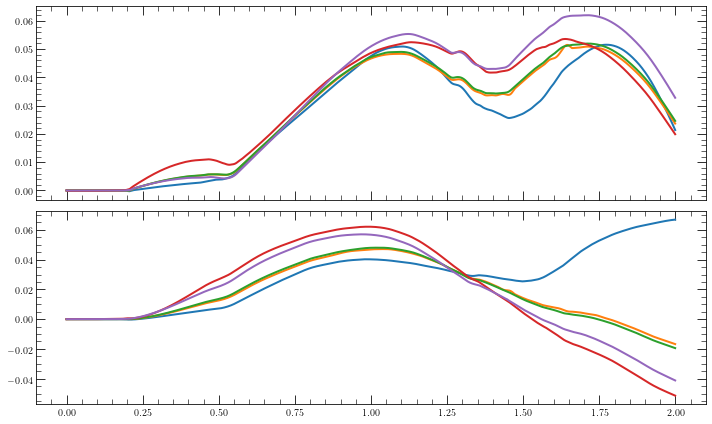

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)
axs = axs.ravel()
axs[0].plot(ds.solution.t, diff_x.T)
axs[1].plot(ds.solution.t, diff_y.T)
fig.tight_layout()
plt.show()